# CosmoDC2 - Hack on Halos - Appendix

# Galaxy Clusters & Velocity Appendix: Peaks in the Halo mass distribution

Author: Julien Peloton [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-01-04  
Estimated running time: < 5 min.

This notebook, with the help of Apache Spark, inspects the peaks found in the halo mass distribution in the companion notebook.

**Summary:**

If we look at the distribution of halo masses in cosmoDC2, all seem OK. But if we look at the same distribution after filtering objects according to the stellar mass, we start to see peaks in the distribution. These peaks are regularly spaced in log, and their position is independent on the stellar mass cut applied.


**Useful links:**

- Main issue: https://github.com/LSSTDESC/DC2-analysis/issues/57
- Potential update of the cosmoDC2 simulation: https://github.com/LSSTDESC/cosmodc2/issues/84

**Logistics:** 

This notebook is intended to be run through the JupyterHub NERSC interface with the desc-pyspark kernel. The kernel is automatically installed in your environment when you use the kernel setup script:

```bash
source /global/common/software/lsst/common/miniconda/kernels/setup.sh
```

In [1]:
from typing import Iterator, Generator, Any

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

from scipy.optimize import curve_fit

from pyspark.sql.functions import pandas_udf , PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

In [2]:
from time import time

# Spark Session

In [3]:
# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull class to benchmark
class Timer:
    """ A simple class for printing elapsed time (s) since last call
    """
    def __init__(self):
        self.t0 = time()
    
    def start(self):
        self.t0 = time()
        
    def split(self):
        t1 = time()
        print("{:2.1f}s".format(t1 - self.t0))

timer = Timer()

spark session started


# Loading CosmoDC2 data with Spark

Apache Spark has no efficient PySpark connector to read data in hdf5 file. Therefore we first converted the cosmoDC2 data set into parquet (similar to what DPDD tools offer). For the purpose of this notebook, we only convert a few columns of interest. The file is accessible at NERSC for DESC members.

In [4]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-09-03 20:04 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [5]:
timer.start()

# Path to cosmoDC2 (parquet format)
filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image.parquet"
#filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet"
#filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet"

# Spark DataFrame
df = spark.read.parquet(filename)

# Le's inspect the schema of the data
df.printSchema()

# Number of objects in the catalog
print("Number of rows: {}".format(df.count()))

timer.split()

root
 |-- Mag_true_g_lsst_z0: float (nullable = true)
 |-- Mag_true_z_lsst_z0: float (nullable = true)
 |-- ra: float (nullable = true)
 |-- mag_y: float (nullable = true)
 |-- mag_z: float (nullable = true)
 |-- size_true: float (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- position_x: float (nullable = true)
 |-- mag_g: float (nullable = true)
 |-- Mag_true_u_lsst_z0: float (nullable = true)
 |-- mag_true_r: float (nullable = true)
 |-- position_angle_true: float (nullable = true)
 |-- mag_true_g: float (nullable = true)
 |-- stellar_mass: float (nullable = true)
 |-- Mag_true_y_lsst_z0: float (nullable = true)
 |-- position_y: float (nullable = true)
 |-- mag_true_i: float (nullable = true)
 |-- redshift: float (nullable = true)
 |-- Mag_true_i_lsst_z0: float (nullable = true)
 |-- mag_r: float (nullable = true)
 |-- mag_true_y: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- mag_true_u: float (nullable = true)
 |-- Mag_true_r_lsst_z0: float (nullable = 

# Data preparation: selecting halos by their stellar mass

In [6]:
# .sample(fraction=0.05).collect()

In [7]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
# In addition we select halo members according to their stellar mass
stellar_masses_cut = [1e9, 1e10, 5e10, 1e11]
full_data = []
for stellar_mass_cut in stellar_masses_cut:
    print("stellar_mass_cut = {}".format(stellar_mass_cut))
    df_filt = df.filter("halo_id > 0").filter("stellar_mass > {}".format(stellar_mass_cut)).sample(fraction=0.05)

    # Group data by halos and compute the number of halo members
    df_disp = df_filt.groupBy("halo_id").count()

    # Add back the original DataFrame columns
    # and select only central member for halo 
    # (unique halo mass for a halo)
    data_joined = df_filt.join(df_disp, "halo_id")\
        .filter("is_central == True")\
        .select("stellar_mass", 'count')\
        .dropna()

    # Collect the data from the executors to the driver
    data = data_joined.collect()
    full_data.append(data)

stellar_mass_cut = 1000000000.0
stellar_mass_cut = 10000000000.0
stellar_mass_cut = 50000000000.0
stellar_mass_cut = 100000000000.0


# Halo mass distribution

(for the version without cut, see the main notebook)

Number of entries ($M_*$ > 1.0e+09 $M_\odot$): 2671591
Number of entries ($M_*$ > 1.0e+10 $M_\odot$): 694292
Number of entries ($M_*$ > 5.0e+10 $M_\odot$): 176786
Number of entries ($M_*$ > 1.0e+11 $M_\odot$): 62069


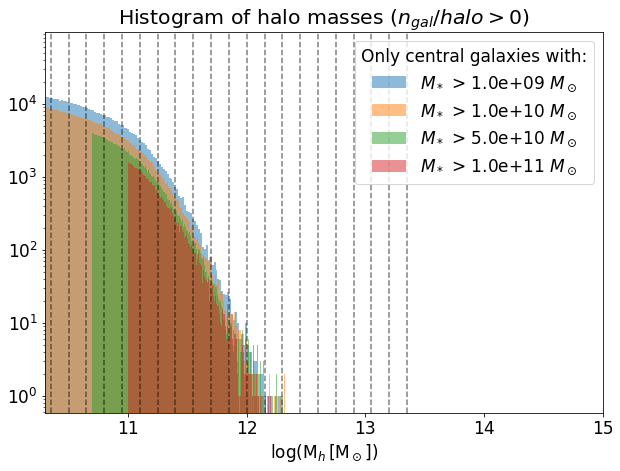

In [8]:
matplotlib.rcParams.update({'font.size': 17})

fig = plt.figure(figsize=(10, 7))
plt.title("Histogram of halo masses ($n_{{gal}}/halo > 0$)")

# Plot peak locations (empirical!)
for k in range(90):
    plt.axvline(k*0.15, ls='--', color='k', alpha=0.5)

# Plot halo mass data
for index, stellar_mass_cut in enumerate(stellar_masses_cut):
    mass, count = np.transpose(full_data[index])
    print(r"Number of entries ($M_*$ > {:.1e} $M_\odot$): {}".format(stellar_mass_cut, len(mass)))
    plt.hist(np.log10(mass), bins=200, alpha=0.5, label='$M_*$ > {:.1e} $M_\odot$'.format(stellar_mass_cut))
    

plt.xlim(10.3, 15)
plt.xlabel(r'$\log({\rm M}_h \, [{\rm M}_\odot])$')
plt.yscale('log')
plt.legend(title="Only central galaxies with:")
plt.show()

The position $p$ of the peaks is independent of the cut on the stellar mass, and it seems to follow:

$$ \log(M_{h}^{p}) = 0.15 * p $$


Let's plot the same distribution, but selecting only halos with at least 2 members

Number of entries ($M_*$ > 1.0e+09 $M_\odot$): 34956
Number of entries ($M_*$ > 1.0e+10 $M_\odot$): 8617
Number of entries ($M_*$ > 5.0e+10 $M_\odot$): 1563
Number of entries ($M_*$ > 1.0e+11 $M_\odot$): 393


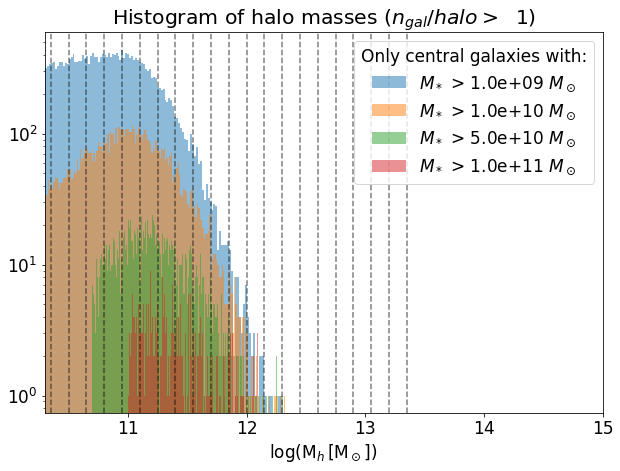

In [9]:
matplotlib.rcParams.update({'font.size': 17})

mincount = 1

fig = plt.figure(figsize=(10, 7))
plt.title("Histogram of halo masses ($n_{{gal}}/halo >$  {})".format(mincount))

# Plot peak locations (empirical!)
for k in range(90):
    plt.axvline(k*0.15, ls='--', color='k', alpha=0.5)

# Plot halo mass data
for index, stellar_mass_cut in enumerate(stellar_masses_cut):
    mass, count = np.transpose(full_data[index])
    mask = count > mincount
    print(r"Number of entries ($M_*$ > {:.1e} $M_\odot$): {}".format(stellar_mass_cut, len(mass[mask])))
    plt.hist(np.log10(mass[mask]), bins=200, alpha=0.5, label='$M_*$ > {:.1e} $M_\odot$'.format(stellar_mass_cut))
    

plt.xlim(10.3, 15)
plt.xlabel(r'$\log({\rm M}_h \, [{\rm M}_\odot])$')
plt.yscale('log')
plt.legend(title="Only central galaxies with:")
plt.show()

The peaks are even sharper at low mass.

**Question:** Is that expected?

**Answer:** The saw tooth shape is indeed expected (but probably not wanted!) from the way N-body simulations are done. A detailed discussion can be found at https://github.com/LSSTDESC/DC2-analysis/issues/57, and an action item for the simulation has been opened at https://github.com/LSSTDESC/cosmodc2/issues/84.

# Moving to cuts on the Magnitude

It has been suggested to not use the stellar mass for selecting halos (not a direct observable), but rather a more physically motivated quantity like magnitudes/colors. In this part, we select the apparent magnitude, lensed, in i band. This might not be the best quantity to look at, but just want to play with something else than the stellar mass.

In [10]:
# let's select halo masses, and magnitudes (i, g, u) for 
# the central galaxy.
data = df.filter("halo_id > 0")\
    .filter("is_central == True")\
    .select(["stellar_mass", "mag_i", "mag_g", "mag_u"])\
    .sample(fraction=0.01).collect()

In [11]:
mass, mag_i, mag_g, mag_u = np.transpose(data)
print("Number of rows: {}".format(len(mass)))

Number of rows: 2412098


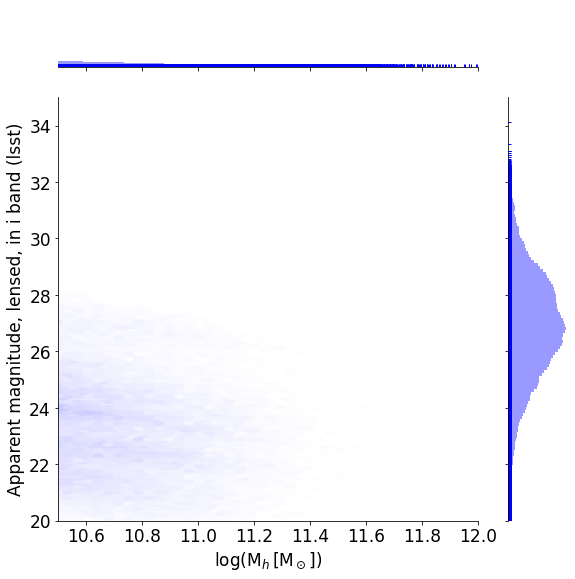

In [12]:
import seaborn as sns

joint_kws = dict(gridsize=200, mincnt=1)
g = sns.jointplot(
    np.log10(mass), 
    mag_i, 
    height=8, space=0.5,
    kind='hex', color='b', 
    xlim=(10.5, 12), ylim=(20, 35),
    joint_kws=joint_kws, 
    marginal_kws=dict(bins=200, rug=True))

g.set_axis_labels(
    r'$\log({\rm M}_h \, [{\rm M}_\odot])$', 
    'Apparent magnitude, lensed, in i band (lsst)')

plt.show()

Hum, the stripes are still there... Let's have a look at 1D halo mass distribution as a function of magnitude:

In [13]:
# We reject synthetic halos - see for example discussion in 
# https://github.com/LSSTDESC/cosmodc2/issues/82
# In addition we select halo members according to their stellar mass
stellar_masses_cut = [25.0, 22.5, 20.0]
full_data = []
for stellar_mass_cut in stellar_masses_cut:
    df_filt = df.filter("halo_id > 0").filter("mag_i < {}".format(stellar_mass_cut)).sample(fraction=0.05)

    # Group data by halos and compute the number of halo members
    df_disp = df_filt.groupBy("halo_id").count()

    # Add back the original DataFrame columns
    # and select only central member for halo 
    # (unique halo mass for a halo)
    data_joined = df_filt.join(df_disp, "halo_id")\
        .filter("is_central == True")\
        .select("stellar_mass", 'count')\
        .dropna()

    # Collect the data from the executors to the driver
    data = data_joined.collect()
    full_data.append(data)

Number of entries (mag_i_lsst < 25.0): 2142567
Number of entries (mag_i_lsst < 22.5): 339898
Number of entries (mag_i_lsst < 20.0): 30305


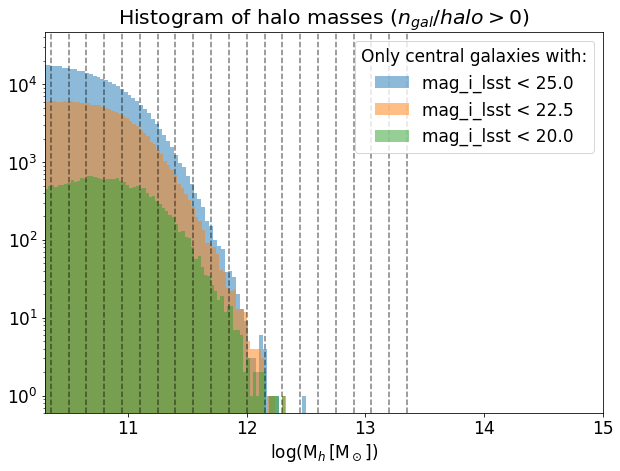

In [14]:
matplotlib.rcParams.update({'font.size': 17})

fig = plt.figure(figsize=(10, 7))
plt.title("Histogram of halo masses ($n_{{gal}}/halo > 0$)")

# Plot peak locations (empirical!)
for k in range(90):
    plt.axvline(k*0.15, ls='--', color='k', alpha=0.5)

# Plot halo mass data
for index, stellar_mass_cut in enumerate(stellar_masses_cut):
    mass, count = np.transpose(full_data[index])
    print(r"Number of entries (mag_i_lsst < {}): {}".format(stellar_mass_cut, len(mass)))
    plt.hist(np.log10(mass), bins=200, alpha=0.5, label='mag_i_lsst < {}'.format(stellar_mass_cut))
    

plt.xlim(10.3, 15)
plt.xlabel(r'$\log({\rm M}_h \, [{\rm M}_\odot])$')
plt.yscale('log')
plt.legend(title="Only central galaxies with:")
plt.show()

Similar to what is seen for cut on the stellar mass... According to Andrew Hearin in [#57](https://github.com/LSSTDESC/DC2-analysis/issues/57), this makes sense as

```
... in the cosmoDC2 model, restframe flux derives from stellar mass, 
which in turn drives from halo mass, so it is expected that this discreteness 
propagates through to these other variables.
```